Files already downloaded and verified


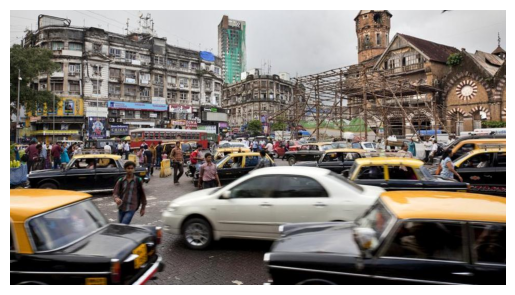

The image likely contains bus, road, pickup_truck, clock, streetcar, skyscraper, elephant, plain, bicycle, train, telephone, motorcycle, woman, girl, bridge, bed, plate, man, and lion.


In [1]:
"""Predicting image contents using CLIP with the labels of CIFAR-100 dataset."""
import os
import clip
import torch
from PIL import Image
from torchvision.datasets import CIFAR100

import matplotlib.pyplot as plt

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load your custom image
image_path = 'urban.jpg'
image = Image.open(image_path)

# Preprocess the image for the model
image_input = preprocess(image).unsqueeze(0).to(device)

# Load CIFAR-100 classes for classification labels
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)
descriptions = cifar100.classes

# Tokenize and process descriptions
text_inputs = torch.cat([clip.tokenize(f"a photo of a {desc}") for desc in descriptions]).to(device)

# Calculate features and similarity
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(len(descriptions))

# Define a threshold for significant probability
significant_threshold = 1  # Adjust this threshold as needed

# Filter predictions based on the significant probability threshold
significant_predictions = [
    cifar100.classes[index] for value, index in zip(values, indices)
    if value.item() * 100 > significant_threshold
]

# Construct a natural language description of the significant predictions
if significant_predictions:
    if len(significant_predictions) > 1:
        predictions_text = ", ".join(significant_predictions[:-1]) + ", and " + significant_predictions[-1]
    else:
        predictions_text = significant_predictions[0]
else:
    predictions_text = "no significant elements detected"

# Display the input image using matplotlib
plt.imshow(image)
plt.axis('off')
plt.show()

description_sentence = f"The image likely contains {predictions_text}."
print(description_sentence)


Files already downloaded and verified
The image features a bustling city street scene with several significant elements. A bus and a pickup truck are visible, indicating the presence of vehicular traffic. The road is prominent, suggesting a busy urban area. A clock can be seen, possibly indicating the time or a landmark in the vicinity. Finally, a streetcar is also present, adding to the transportation theme of the image.


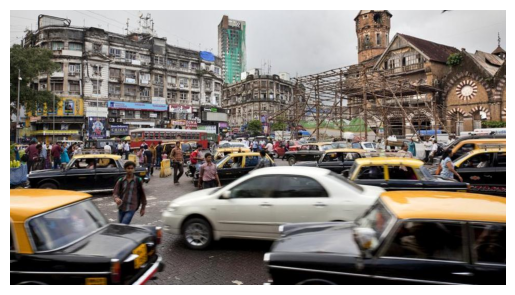

In [1]:
"""Image understanding using the combination of CLIP and GPT-3.5 on CIFAR-100 label vocabulary"""
"""Note: Enter your OpenAI API in openai.api_key"""
import os
import clip
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR100
import openai

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load your custom image
image_path = 'urban.jpg'
image = Image.open(image_path)

# Preprocess the image for the model
image_input = preprocess(image).unsqueeze(0).to(device)

# Load CIFAR-100 classes
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Tokenize and process CIFAR-100 descriptions
descriptions = cifar100.classes
text_inputs = torch.cat([clip.tokenize(f"a photo of a {desc}") for desc in descriptions]).to(device)

# Calculate features and similarity
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)

# Extract top predictions
top_predictions = [cifar100.classes[index] for value, index in zip(values, indices)]

openai.api_type = "azure"
openai.api_base = "https://hhazure-openai-dev.openai.azure.com/"
openai.api_version = "2023-07-01-preview"
# Set OpenAI API configuration (Replace with your actual API key)
openai.api_key = "Your_openAI_API"

some_threshold = 0.01
# Define the conversation message with the CLIP model predictions
prediction_descriptions = [descriptions[index] for value, index in zip(values, indices) if value.item() * 100 > some_threshold]
if prediction_descriptions:
    predictions_text = ", ".join(prediction_descriptions[:-1]) + ", and " + prediction_descriptions[-1]
else:
    predictions_text = "no significant objects"

message_text = [
    {"role": "system", "content": "You are a helpful AI assistant."},
    {"role": "user", "content": f"Describe the image briefly, focusing on significant elements. The image likely contains {predictions_text}."}
]

completion = openai.ChatCompletion.create(
  engine="gpt-35-turbo",
  messages = message_text,
  temperature=0.8,
  max_tokens=800,
  top_p=0.95,
  frequency_penalty=0.5,
  presence_penalty=0.5,
  stop=None
)

# Print the GPT-generated description
print(completion.choices[0].message['content'])

# Display the input image using matplotlib
plt.imshow(image)
plt.axis('off')
plt.show()


Files already downloaded and verified


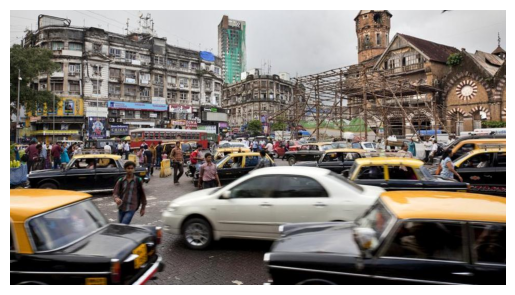

The image is a busy city scene with a variety of vehicles and transportation options. The focus of the image appears to be a bus stopped at a bus stop, with people waiting to board. Behind the bus, there is a road with a pickup truck and a streetcar visible. The streetcar is partially obscured by the bus, and it appears to be stopped or moving slowly. There is also a clock visible on the side of a building, suggesting that the time is around 10:45 AM. The overall impression is one of a bustling, active urban environment.


In [2]:
"""Predicting image contents using the combination of CLIP and open-source mixtral-8x7B-Instruct-v0_1 model with CIFAR-100 labels."""
"""Enter your personal access token in os.environ['CLARIFAI_PAT']. Could be created from https://www.clarifai.com/blog/run-mistral-7b-with-an-api"""

from clarifai_grpc.channel.clarifai_channel import ClarifaiChannel
from clarifai_grpc.grpc.api import resources_pb2, service_pb2, service_pb2_grpc
from clarifai_grpc.grpc.api.status import status_code_pb2
import os
import clip
import torch
from PIL import Image
import matplotlib.pyplot as plt
import requests
from torchvision.datasets import CIFAR100
from clarifai.client.model import Model

os.environ['CLARIFAI_PAT'] = ''

# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Load your custom image
image_path = 'urban.jpg'
image = Image.open(image_path)

# Preprocess the image for the model
image_input = preprocess(image).unsqueeze(0).to(device)

###For CIFAR-100 labels
# Load CIFAR-100 classes
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)
# Tokenize and process CIFAR-100 descriptions
descriptions = cifar100.classes
text_inputs = torch.cat([clip.tokenize(f"a photo of a {desc}") for desc in descriptions]).to(device)

# Calculate features and similarity
with torch.no_grad():
    image_features = model.encode_image(image_input)
    text_features = model.encode_text(text_inputs)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)

# Extract top predictions for CIFA-100 labels
top_predictions = [cifar100.classes[index] for value, index in zip(values, indices)]

some_threshold = 0.01
# Define the conversation message with the CLIP model predictions
prediction_descriptions = [descriptions[index] for value, index in zip(values, indices) if value.item() * 100 > some_threshold]
if prediction_descriptions:
    predictions_text = ", ".join(prediction_descriptions[:-1]) + ", and " + prediction_descriptions[-1]
else:
    predictions_text = "no significant objects"

RAW_TEXT = f'Describe the image briefly, focusing on significant elements. The image likely contains {predictions_text}.'

prompt = f"<s> {RAW_TEXT} [/INST]"

inference_params = dict(temperature=0.8, max_tokens=800, top_k = 95, top_p= 0.95)

# Model Predict
model_prediction = Model("https://clarifai.com/mistralai/completion/models/mixtral-8x7B-Instruct-v0_1").predict_by_bytes(prompt.encode(), input_type="text", inference_params=inference_params)

# Display the input image using matplotlib
plt.imshow(image)
plt.axis('off')
plt.show()

print(model_prediction.outputs[0].data.text.raw)

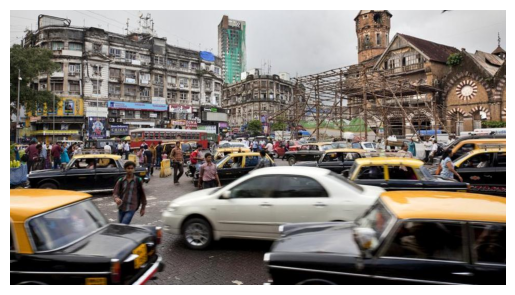

The image shows a busy street scene in India, with several black and yellow taxis on both sides of the road. In the background, there is an old building with a clock tower, partially obscured by scaffolding, indicating that it is under construction or renovation. The architecture of the building suggests a colonial influence. There are people crossing the street and walking on the sidewalks, indicating a bustling urban environment. There is also a double-decker bus in the background, adding to the sense of a busy city. The sky is overcast, suggesting it might be a rainy or cloudy day. The overall feel of the image is one of chaos and movement, characteristic of many Indian cities.


In [1]:
"""Using GPT-4V"""
import os
import requests
import base64
import matplotlib.pyplot as plt
import requests
from PIL import Image


# Configuration
GPT4V_KEY = "Your_OpenAI_API"
IMAGE_PATH = "urban.jpg"
encoded_image = base64.b64encode(open(IMAGE_PATH, 'rb').read()).decode('ascii')
image = Image.open(IMAGE_PATH)
headers = {
    "Content-Type": "application/json",
    "api-key": GPT4V_KEY,
}


payload = {
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Describe the image briefly, focusing on significant elements."
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{encoded_image}"
                    }
                }
            ]
        }
    ],
    "max_tokens": 800
}
GPT4V_ENDPOINT = "https://hhazure-openai-dev.openai.azure.com/openai/deployments/GPT4Vision/chat/completions?api-version=2023-07-01-preview"

# Send request
try:
    response = requests.post(GPT4V_ENDPOINT, headers=headers, json=payload)
    response.raise_for_status()  # Will raise an HTTPError if the HTTP request returned an unsuccessful status code
except requests.RequestException as e:
    raise SystemExit(f"Failed to make the request. Error: {e}")

# Handle the response as needed (e.g., print or process)
response_json = response.json()  # Assuming 'response' is your response object
# Extract the 'content' field
content = response_json['choices'][0]['message']['content']
# Display the input image using matplotlib
plt.imshow(image)
plt.axis('off')
plt.show()
print(content)

In [ ]:
!pip install -q transformers==4.36.0
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0

In [ ]:
"""Running LLaVA in Google Colab"""
from transformers import pipeline, BitsAndBytesConfig
import torch
from PIL import Image
configuration = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

id = "llava-hf/llava-1.5-13b-hf" ##13 billion parameters LLaAVA model. For 7 billion model, use 'llava-1.5-7b-hf'
pipe = pipeline("image-to-text", model=id, model_kwargs={"quantization_config": configuration})

# Path to the image in Google Drive
image_path = '/content/drive/My Drive/Colab Notebooks/urban.jpg'

image = Image.open(image_path).resize((750, 500))
image.show()  
instruction = "USER: <image>\nDescribe this picture\n​ASSISTANT: "

description = pipe(image, prompt=instruction, generate_kwargs={"max_new_tokens": 200})
print(description[0]['generated_text'])